In [1]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy import signal
from scipy.stats import levy_stable
from symulacja_py import impsim
from tqdm.notebook import tqdm 
#%matplotlib widget

In [2]:
def create_signal(alpha, impulse_amplitude, seed, fs = 25000):
    
    fmod = 30
    f_center = 5000
    bandwidth = 1500
    shift = 0

    amp_imp = impulse_amplitude
    alfa = alpha
    skala = 0.5

    varsize = 2*fs
    tt_ts = np.linspace(1/fs,varsize/fs,varsize)
    #szum = np.random.normal(0,skala,varsize) #szum Gaussowski

    szum = levy_stable.rvs(alfa,0,0,skala,varsize, random_state=seed)  #szum alfa-stabilny

    signal_l = 9*impsim(fs,varsize,fmod,amp_imp,f_center,bandwidth,shift)+szum
    return signal_l


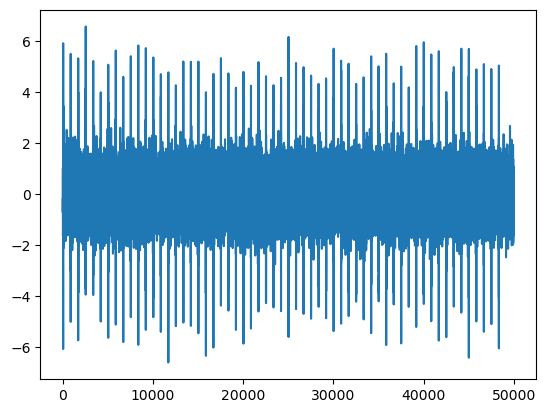

In [3]:
s1 = create_signal(2,1,1,25000)
s2 = create_signal(2,1,1,20000)
s3 = create_signal(2,0,1,25000)
s4 = create_signal(2,0,1,20000)
f,ax = plt.subplots()
ax.plot(np.arange(0,len(s1)),s1)
plt.show()

In [4]:
data = s1#-s4
dims = np.arange(100,1000)
scores = np.zeros_like(dims, dtype=float)

for i in tqdm(range(0,len(dims))):
    #dim = 3*833#417# half period
    dim = dims[i]
    delay = len(data)//dim
    #print("delay", delay)
    skip = 1#200#0#100
    #print(dim*delay)
    #print(len(data[0])/24)

    #print("===============computing SWE====================")
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform([data])[0]
    if len(point_clouds>100):
        skip = max(len(point_clouds)//100,1)
        tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
        point_clouds = tde.transform([data])[0]
    print(dim,delay,skip)
    point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
    point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]
    pc=point_clouds
    ac = gd.RipsComplex(points =pc)
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)
    lifetimes = pd[:,1]-pd[:,0]
    if len(lifetimes>0):
        scores[i] = np.max(lifetimes)

  0%|          | 0/900 [00:00<?, ?it/s]

100 500 5
101 495 5
102 490 5
103 485 5
104 480 5
105 476 4
106 471 5
107 467 4
108 462 5


KeyboardInterrupt: 

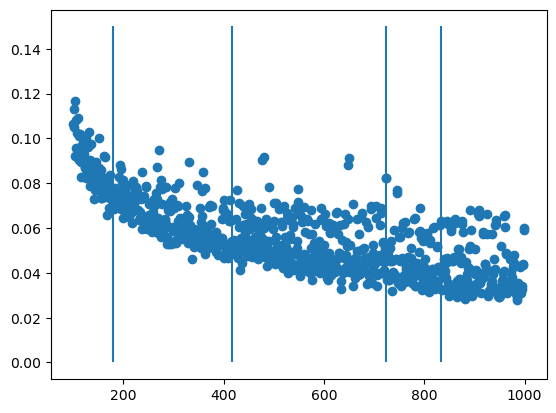

In [6]:
f,ax = plt.subplots()
ax.scatter(dims, scores)
ax.vlines([179,416.5,723,833],0,0.15)
plt.show()

In [7]:
dims[np.argmax(scores)]

103

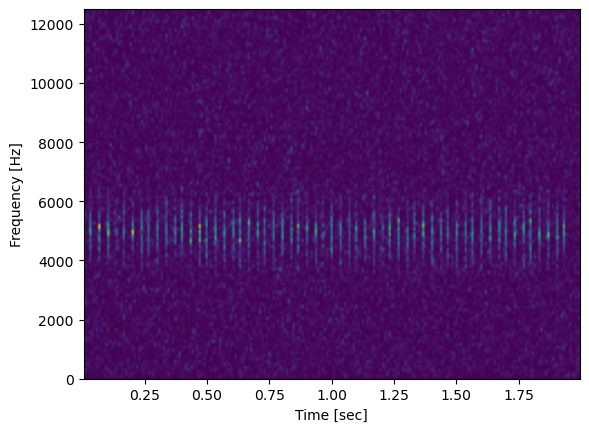

In [5]:
import numpy as np

from scipy import signal

from scipy.fft import fftshift



f, t, Sxx = signal.spectrogram(data, 25000)

plt.pcolormesh(t, f, Sxx, shading='gouraud')

plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')

plt.show()

In [21]:
t=240
tde = TimeDelayEmbedding(dim = 10, delay=200, skip=2)
point_clouds = tde.transform([data[100*t:100*t+2000]])[0]
point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
#point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]
#pc=point_clouds
#pc
np.sum(point_clouds**2, 1)


array([13.96288176,  5.01792861,  9.09349545, 12.69521817, 11.58120719,
        6.5207585 ,  7.16944266,  6.48759986,  5.24255507,  5.48593058,
        2.12751993,  4.52920607,  5.9101129 ,  2.33534309,  8.24298984,
        3.43862383,  4.73411905, 30.76881357, 41.87646596, 15.47994275,
        3.49045472,  9.18839789,  8.21733666,  7.033574  ,  9.12385115,
        3.3677663 ,  2.62758307,  4.6166254 ,  4.46934136,  3.05228868,
        3.15357568,  4.60054929, 27.49781512,  4.04960422,  2.53793671,
       18.45433724, 17.96070328, 11.20405647,  7.79547613,  3.32437894,
        3.55685937,  3.86442217,  8.33061845,  5.07938948,  6.81917839,
        2.97983975,  5.03103213,  2.36136395,  8.20797815,  4.44468567,
        2.30886942,  4.00947567,  2.58045554,  3.45755149,  4.35862759,
        2.30404716,  3.5133568 ,  4.75038513,  7.0961117 ,  0.96458144,
        3.27710867,  3.93764678,  3.54898233,  3.04295678,  6.52163607,
        3.43144052,  4.80278728,  4.05372637,  4.38965083,  3.69

In [6]:
short_time_scores = np.zeros_like(Sxx)
for t in range(0,len(Sxx)):
    for f in range(0,len(Sxx[0])):
        #dim = 3*833#417# half period
        dim = f+1
        delay = 200//dim#len(data)//dim
        #print("delay", delay)
        skip = 1#200#0#100
        #print(dim*delay)
        #print(len(data[0])/24)

        #print("===============computing SWE====================")
        tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
        point_clouds = tde.transform([data[100*t:100*t+200]])[0]
        if len(point_clouds>100):
            skip = max(len(point_clouds)//100,1)
            tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
            point_clouds = tde.transform([data])[0]
        print(dim,delay,skip)
        point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
        point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]
        pc=point_clouds
        ac = gd.RipsComplex(points =pc)
        st = ac.create_simplex_tree(max_dimension = 2)
        st.compute_persistence()
        pd = st.persistence_intervals_in_dimension(1)
        lifetimes = pd[:,1]-pd[:,0]
        if len(lifetimes>0):
            short_time_scores[t,f] = np.max(lifetimes)

1 200 2


: 

: 

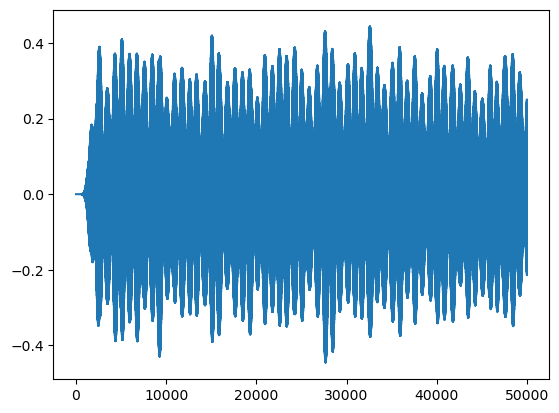

In [53]:

data=create_signal(1.9,2,0)

sos = signal.cheby1(10, 1, [4968.75 ,  5015.625], btype='bandpass', fs=25000, output='sos')
filtered = signal.sosfilt(sos, data)


f,ax = plt.subplots()
ax.plot(np.arange(len(data)), filtered)
plt.show()

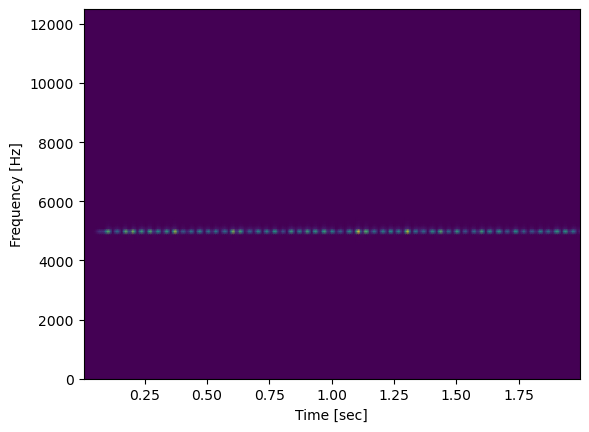

In [54]:
f, t, Sxx = signal.spectrogram(filtered, 25000)

plt.pcolormesh(t, f, Sxx, shading='gouraud')

plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')

plt.show()

7.903710591027454


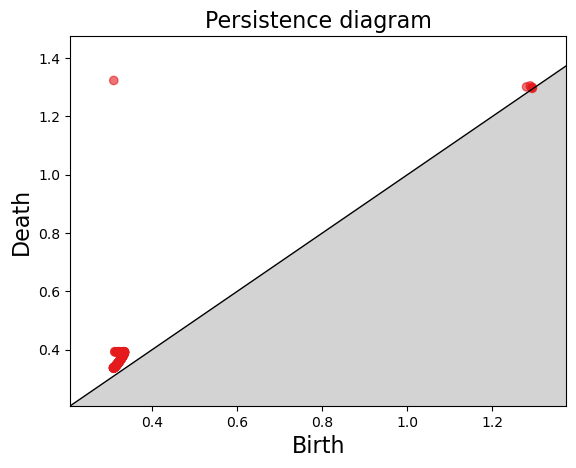

In [55]:
tde = TimeDelayEmbedding(dim = dim, delay=delay , skip=1)
point_clouds = tde.transform([filtered])[0]
ac = gd.RipsComplex(points =pc)
st = ac.create_simplex_tree(max_dimension = 2)
st.compute_persistence()
pd = st.persistence_intervals_in_dimension(1)
gd.plot_persistence_diagram(pd)
print(gd.hera.wasserstein_distance(pd,[], order = 1, internal_p=1))

In [58]:
frequencies = np.linspace(0,12000,260)
scores = np.zeros_like(frequencies)

for i in range(1,len(frequencies)-5):
    dim = 723
    delay = len(filtered)//dim
    sos = signal.cheby1(10, 1, [frequencies[i],frequencies[i+4]], btype='bandpass', fs=25000, output='sos')
    filtered = signal.sosfilt(sos, data)
    tde = TimeDelayEmbedding(dim = dim, delay=delay , skip=1)
    point_clouds = tde.transform([filtered])[0]
    #if len(point_clouds>100):
    #    skip = max(len(point_clouds)//100,1)
    #    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    #    point_clouds = tde.transform([data])[0]
    print(dim,delay,skip)
    point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
    point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]
    pc=point_clouds
    ac = gd.RipsComplex(points =pc)
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)
    lifetimes = pd[:,1]-pd[:,0]
    #scores[i] = gd.hera.wasserstein_distance(pd,[], order = 2, internal_p=2)
    if len(lifetimes>0):
        scores[i] = np.max(lifetimes)

723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
723 69 1
7

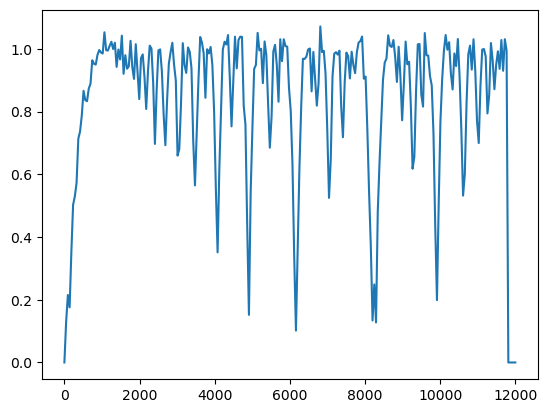

In [61]:
f,ax = plt.subplots()
ax.plot(frequencies, scores)
plt.show()

In [34]:
frequencies

array([    0.   ,    46.875,    93.75 ,   140.625,   187.5  ,   234.375,
         281.25 ,   328.125,   375.   ,   421.875,   468.75 ,   515.625,
         562.5  ,   609.375,   656.25 ,   703.125,   750.   ,   796.875,
         843.75 ,   890.625,   937.5  ,   984.375,  1031.25 ,  1078.125,
        1125.   ,  1171.875,  1218.75 ,  1265.625,  1312.5  ,  1359.375,
        1406.25 ,  1453.125,  1500.   ,  1546.875,  1593.75 ,  1640.625,
        1687.5  ,  1734.375,  1781.25 ,  1828.125,  1875.   ,  1921.875,
        1968.75 ,  2015.625,  2062.5  ,  2109.375,  2156.25 ,  2203.125,
        2250.   ,  2296.875,  2343.75 ,  2390.625,  2437.5  ,  2484.375,
        2531.25 ,  2578.125,  2625.   ,  2671.875,  2718.75 ,  2765.625,
        2812.5  ,  2859.375,  2906.25 ,  2953.125,  3000.   ,  3046.875,
        3093.75 ,  3140.625,  3187.5  ,  3234.375,  3281.25 ,  3328.125,
        3375.   ,  3421.875,  3468.75 ,  3515.625,  3562.5  ,  3609.375,
        3656.25 ,  3703.125,  3750.   ,  3796.875, 